In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multilabel-video-game-dataset-v2/y_test.csv
/kaggle/input/multilabel-video-game-dataset-v2/X_test.csv
/kaggle/input/multilabel-video-game-dataset-v2/y_val.csv
/kaggle/input/multilabel-video-game-dataset-v2/y_train.csv
/kaggle/input/multilabel-video-game-dataset-v2/X_train.csv
/kaggle/input/multilabel-video-game-dataset-v2/X_val.csv
/kaggle/input/multilabel-video-game-dataset-v2/vgame_fulldata.csv


In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import string
from wordcloud import STOPWORDS
import gc
import re
import operator
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# 📌 Data Import and Validation
---

### 📝 Import Data and Check Data Distribution

In [3]:
# train df
X_train = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/X_train.csv')
y_train = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/y_train.csv')

# test df
X_test = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/X_test.csv')
y_test = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/y_test.csv')

# val df
X_val = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/X_val.csv')
y_val = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/y_val.csv')

In [4]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}\n')

print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}\n')

print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}\n')

X_train shape: (117197, 2)
y_train shape: (117197, 12)

X_val shape: (14650, 2)
y_val shape: (14650, 12)

X_test shape: (14650, 2)
y_test shape: (14650, 12)



### 📝 Tiny EDA for Train, Test, and Validation Set

In [5]:
from ast import literal_eval

y_train['new_genrelist'] = y_train['new_genrelist'].apply(literal_eval)
y_test['new_genrelist'] = y_test['new_genrelist'].apply(literal_eval)
y_val['new_genrelist'] = y_val['new_genrelist'].apply(literal_eval)

In [6]:
genre_cols = ['action','adventure','arcade','cardboard','indie','puzzle','quiz','rpg','simulation','strategy']

,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,0.798954,0.633864,0.916517,0.985588,0.566269,0.884792,0.992491,0.862104,0.737425,0.813818
1,0.201046,0.366136,0.083483,0.014412,0.433731,0.115208,0.007509,0.137896,0.262575,0.186182


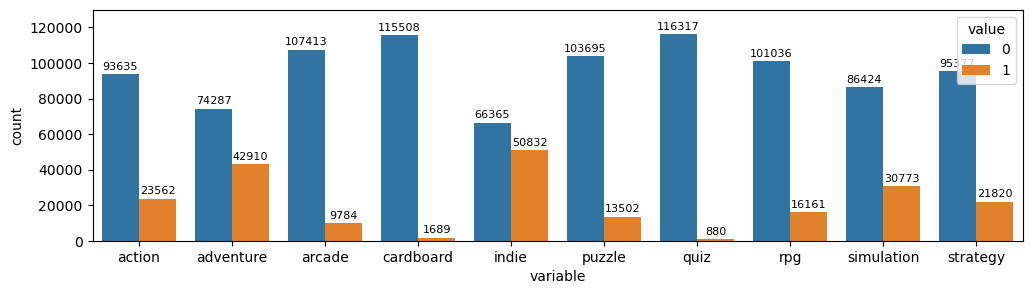

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

display(y_train[genre_cols].apply(lambda x: x.value_counts(normalize=True)))

plt.figure(figsize=(12,3))
ax = sns.countplot(x="variable", hue="value", data=pd.melt(y_train[genre_cols]))
ax.set_ylim(0,130000)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=2, fontsize=8)

plt.show()

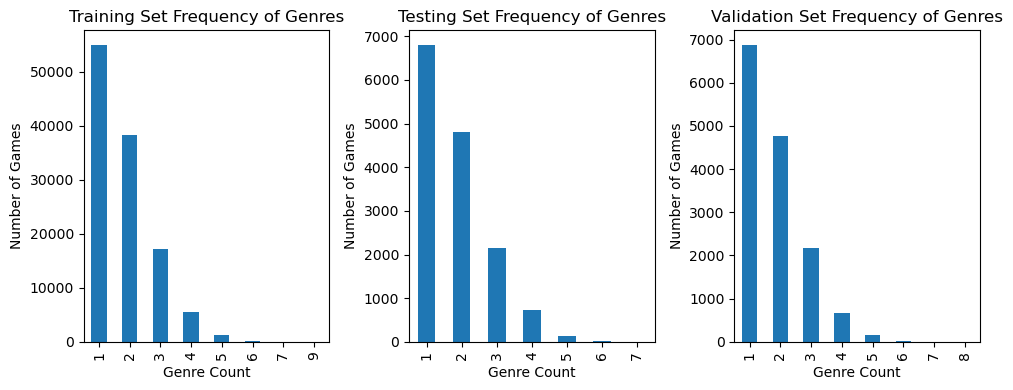

In [8]:
def freq_counter(df):
    freq_count = df['new_genrelist'].apply(len)
    return freq_count.value_counts()

training_freqcount = freq_counter(y_train)
testing_freqcount = freq_counter(y_test)
validation_freqcount = freq_counter(y_val)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
training_freqcount.plot(kind='bar', title='Training Set Frequency of Genres', xlabel='Genre Count', ylabel='Number of Games', ax=ax1)
testing_freqcount.plot(kind='bar', title='Testing Set Frequency of Genres', xlabel='Genre Count', ylabel='Number of Games', ax=ax2)
validation_freqcount.plot(kind='bar', title='Validation Set Frequency of Genres', xlabel='Genre Count', ylabel='Number of Games', ax=ax3)
plt.tight_layout()

### 📝 Compile genre tags binary results to list then merge

In [9]:
y_train['compiled_genrelist'] = y_train[genre_cols].values.tolist()
y_val['compiled_genrelist'] = y_val[genre_cols].values.tolist()

merged_trainset = pd.merge(X_train, y_train, on='id')[['clean_summary', 'compiled_genrelist']]
merged_valset = pd.merge(X_val, y_val, on='id')[['clean_summary', 'compiled_genrelist']]

In [10]:
display(merged_trainset)
display(merged_valset)

,clean_summary,compiled_genrelist
0,a grid based single local multiplayer strategy...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,top view racing game for wiiware by the makers...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,the idolmaster dearly stars is a japanese life...,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0]"
3,my daughter who was supposed to be dead is rig...,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]"
4,espn baseball tonight is a baseball game with ...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
...,...,...
117192,kero kero king is the predecessor to ribbit ki...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
117193,mighty chameleon brothers will remind you of o...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
117194,take control of one of the iconic british loco...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
117195,alchemist of war is a casual card game with cr...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"


,clean_summary,compiled_genrelist
0,a new legend begins here build and manage a to...,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 1]"
1,meet barnsley a lazy good for nothing badger w...,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,fire up a wild ride across the cosmos with a f...,"[1, 1, 0, 0, 0, 0, 0, 1, 0, 0]"
3,a special bonus disc that contained the both t...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,kings cross a unique mix of strategy rpg and t...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1]"
...,...,...
14645,own the child of light ultimate edition with t...,"[1, 1, 0, 0, 0, 0, 0, 1, 0, 1]"
14646,a side scroller adventure game with a slight t...,"[1, 1, 0, 0, 1, 1, 0, 0, 0, 0]"
14647,welcome to the chess game of tomorrow yesterye...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1]"
14648,a capcom developed adventure game released exc...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


# 📌 Handling Dataset Imbalance
---

In [11]:
def get_class_weights(targets):
    num_samples = len(targets)
    print(num_samples)
    num_classes = targets.shape[1]
    print(num_classes)
    class_counts = torch.sum(targets, axis=0)
    print(class_counts)
    class_weights = torch.Tensor([num_samples / (num_classes * count) for count in class_counts])
    print(class_weights)
    
    return class_weights

In [12]:
class_weights = get_class_weights(torch.tensor(y_train[genre_cols].values, dtype=torch.float32))

117197
10
tensor([23562., 42910.,  9784.,  1689., 50832., 13502.,   880., 16161., 30773.,
        21820.])
tensor([ 0.4974,  0.2731,  1.1978,  6.9388,  0.2306,  0.8680, 13.3178,  0.7252,
         0.3808,  0.5371])


# 📌 Preparation for Modelling
---

### 📝 Defining the Dataset Class

In [13]:
from torch.utils.data import Dataset, DataLoader

class MultiLabelDataset(Dataset):
    
    def __init__(self, df, tokenizer, max_len, new_data=False):
        self.tokenizer = tokenizer
        self.data = df
        self.text = df.clean_summary
        self.new_data = new_data
        self.max_len = max_len
        
        if not new_data:
            self.targets = self.data.compiled_genrelist
            
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = str(self.text[index])
        
        inputs = self.tokenizer.encode_plus(text,None,
                                           add_special_tokens=True,
                                           max_length=self.max_len,
                                           pad_to_max_length=True,
                                           return_token_type_ids=True)
        out = {
            "input_ids": torch.tensor(inputs['input_ids'], dtype=torch.long),
            "attention_mask": torch.tensor(inputs['attention_mask'], dtype=torch.long),
            "token_type_ids": torch.tensor(inputs['token_type_ids'], dtype=torch.long)
        }
        if not self.new_data:
            out["targets"] = torch.tensor(self.targets[index], dtype=torch.float)
            
        return out

### 📝 Defining the Configuration

In [14]:
MAX_LEN = 320
EPOCHS = 10
LEARNING_RATE = 1e-05
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda:0'

### 📝 Setting the Seeds

In [15]:
import os
import random
import torch

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

### 📝 Tokenizing and Creating Dataset then Loading it to the DataLoader

In [16]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)
train_set = MultiLabelDataset(merged_trainset, tokenizer, MAX_LEN)
val_set = MultiLabelDataset(merged_valset, tokenizer, MAX_LEN)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=8)

# 📌 Model Development
---

### 📝 Defining DistilBERT Class Model

In [17]:
from transformers import DistilBertModel

class DistilBertClass(torch.nn.Module):
    def __init__(self):
        super(DistilBertClass, self).__init__()
        
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.classifier = torch.nn.Sequential(torch.nn.Linear(768, 768),
                                             torch.nn.ReLU(),
                                             torch.nn.Dropout(0.1),
                                             torch.nn.Linear(768, 10))
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        out = hidden_state[:,0]
        out = self.classifier(out)
        return out

### 📝 Initializing the Model and Moving it to GPU

In [18]:
model = DistilBertClass()
model.to(DEVICE)
print(f"Model on {DEVICE}")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model on cuda:0


### 📝 Defining Optimizer and Loss Function

In [19]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

class_weights = class_weights.to(DEVICE)
def loss_fn(outputs, targets):
    return torch.nn.functional.binary_cross_entropy_with_logits(outputs, targets, pos_weight=torch.tensor(class_weights))

### 📝 Defining Training Loop

In [20]:
from tqdm.auto import tqdm

train_loss_values = [[] for i in range(EPOCHS)]

def train(epoch):
    model.train()
    
    latest_loss = 0
    
    for _, data in tqdm(enumerate(train_loader)):
        input_ids = data['input_ids'].to(DEVICE, dtype=torch.long)
        attention_mask = data['attention_mask'].to(DEVICE, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)
        targets = data['targets'].to(DEVICE, dtype=torch.float)
        
        outputs = model(input_ids, attention_mask, token_type_ids)
        
        loss = loss_fn(outputs, targets)
        if _ % 500 == 0:
            print(f"Epoch: {epoch}, Train Loss: {loss.item()}")
            train_loss_values[epoch].append(loss.item())
        latest_loss = loss.item()
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    print(f"FINAL - Epoch: {epoch}, Latest Loss: {loss.item()}")

### 📝 Defining Validation Loop

In [21]:
from sklearn import metrics

def validate():
    model.eval()

    fin_targets = []
    fin_outputs = []
    latest_loss = 0

    with torch.inference_mode():
        for _, data in tqdm(enumerate(val_loader, 0)):
            ids = data['input_ids'].to(DEVICE, dtype=torch.long)
            mask = data['attention_mask'].to(DEVICE, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)
            targets = data['targets'].to(DEVICE, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

            loss = loss_fn(outputs, targets)
            latest_loss = loss.item()
      
    fin_outputs = np.array(fin_outputs) >= 0.5
    accuracy = metrics.accuracy_score(fin_targets, fin_outputs)
    f1_score_micro = metrics.f1_score(fin_targets, fin_outputs, average='micro')
    f1_score_macro = metrics.f1_score(fin_targets, fin_outputs, average='macro') 

    return {
        "Accuracy Score": accuracy,
        "F1 score(micro)": f1_score_micro,
        "F1 score(macro)": f1_score_macro,
        "EPOCH Validation Loss": latest_loss
    }

# 📌 Model Training/Finetuning
---

### 📝 Execute Training and Validation Process

In [22]:
for epoch in range(EPOCHS):
  train(epoch)
  print(validate())
  print('#' * 30)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 0, Train Loss: 0.6275141835212708
Epoch: 0, Train Loss: 0.2838606834411621
Epoch: 0, Train Loss: 0.33781856298446655
Epoch: 0, Train Loss: 0.25045064091682434
Epoch: 0, Train Loss: 0.2849096357822418
Epoch: 0, Train Loss: 0.3371480405330658
Epoch: 0, Train Loss: 0.180328831076622
Epoch: 0, Train Loss: 0.18381528556346893
FINAL - Epoch: 0, Latest Loss: 0.1833564043045044


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.23133105802047782, 'F1 score(micro)': 0.4494484799569545, 'F1 score(macro)': 0.44447689664156337, 'EPOCH Validation Loss': 0.1564597487449646}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 1, Train Loss: 0.1623372882604599
Epoch: 1, Train Loss: 0.17972101271152496
Epoch: 1, Train Loss: 0.21606414020061493
Epoch: 1, Train Loss: 0.21460822224617004
Epoch: 1, Train Loss: 0.3935771882534027
Epoch: 1, Train Loss: 0.16717074811458588
Epoch: 1, Train Loss: 0.18859925866127014
Epoch: 1, Train Loss: 0.20304469764232635
FINAL - Epoch: 1, Latest Loss: 0.1794077754020691


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.26764505119453924, 'F1 score(micro)': 0.49666408068269974, 'F1 score(macro)': 0.491356241877115, 'EPOCH Validation Loss': 0.13799138367176056}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 2, Train Loss: 0.1571955531835556
Epoch: 2, Train Loss: 0.1407943069934845
Epoch: 2, Train Loss: 0.18754766881465912
Epoch: 2, Train Loss: 0.2258390635251999
Epoch: 2, Train Loss: 0.19322840869426727
Epoch: 2, Train Loss: 0.13397294282913208
Epoch: 2, Train Loss: 0.19439224898815155
Epoch: 2, Train Loss: 0.1266985386610031
FINAL - Epoch: 2, Latest Loss: 0.3539767563343048


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.27993174061433446, 'F1 score(micro)': 0.5122311862823937, 'F1 score(macro)': 0.505085899073711, 'EPOCH Validation Loss': 0.13675619661808014}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 3, Train Loss: 0.17152854800224304
Epoch: 3, Train Loss: 0.13868500292301178
Epoch: 3, Train Loss: 0.11721990257501602
Epoch: 3, Train Loss: 0.15274158120155334
Epoch: 3, Train Loss: 0.19886083900928497
Epoch: 3, Train Loss: 0.18457411229610443
Epoch: 3, Train Loss: 0.18963830173015594
Epoch: 3, Train Loss: 0.18731391429901123
FINAL - Epoch: 3, Latest Loss: 0.10773106664419174


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.3004778156996587, 'F1 score(micro)': 0.5385103413272427, 'F1 score(macro)': 0.526571501164742, 'EPOCH Validation Loss': 0.12355606257915497}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 4, Train Loss: 0.161285862326622
Epoch: 4, Train Loss: 0.15259949862957
Epoch: 4, Train Loss: 0.13918668031692505
Epoch: 4, Train Loss: 0.1608479619026184
Epoch: 4, Train Loss: 0.1525886058807373
Epoch: 4, Train Loss: 0.13443724811077118
Epoch: 4, Train Loss: 0.17903552949428558
Epoch: 4, Train Loss: 0.1507445126771927
FINAL - Epoch: 4, Latest Loss: 0.10908592492341995


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.3155631399317406, 'F1 score(micro)': 0.5681130915795943, 'F1 score(macro)': 0.5352522792082425, 'EPOCH Validation Loss': 0.12452779710292816}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 5, Train Loss: 0.12472516298294067
Epoch: 5, Train Loss: 0.14012204110622406
Epoch: 5, Train Loss: 0.13933733105659485
Epoch: 5, Train Loss: 0.14917413890361786
Epoch: 5, Train Loss: 0.14287999272346497
Epoch: 5, Train Loss: 0.13643503189086914
Epoch: 5, Train Loss: 0.13722474873065948
Epoch: 5, Train Loss: 0.15326234698295593
FINAL - Epoch: 5, Latest Loss: 0.13159368932247162


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.29699658703071674, 'F1 score(micro)': 0.5328033809619642, 'F1 score(macro)': 0.5311210391454682, 'EPOCH Validation Loss': 0.129429891705513}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 6, Train Loss: 0.10881121456623077
Epoch: 6, Train Loss: 0.14901460707187653
Epoch: 6, Train Loss: 0.14072993397712708
Epoch: 6, Train Loss: 0.12278864532709122
Epoch: 6, Train Loss: 0.1011473685503006
Epoch: 6, Train Loss: 0.1669793576002121
Epoch: 6, Train Loss: 0.14065229892730713
Epoch: 6, Train Loss: 0.1599082350730896
FINAL - Epoch: 6, Latest Loss: 0.10644607245922089


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.305938566552901, 'F1 score(micro)': 0.5507153744038547, 'F1 score(macro)': 0.5413063928669068, 'EPOCH Validation Loss': 0.13728617131710052}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 7, Train Loss: 0.09896575659513474
Epoch: 7, Train Loss: 0.16516955196857452
Epoch: 7, Train Loss: 0.10814287513494492
Epoch: 7, Train Loss: 0.115874744951725
Epoch: 7, Train Loss: 0.12694613635540009
Epoch: 7, Train Loss: 0.10582238435745239
Epoch: 7, Train Loss: 0.09562748670578003
Epoch: 7, Train Loss: 0.15176014602184296
FINAL - Epoch: 7, Latest Loss: 0.1436348855495453


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.32409556313993176, 'F1 score(micro)': 0.5836287236789596, 'F1 score(macro)': 0.5634438783055017, 'EPOCH Validation Loss': 0.12930890917778015}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 8, Train Loss: 0.12894845008850098
Epoch: 8, Train Loss: 0.15239237248897552
Epoch: 8, Train Loss: 0.13339005410671234
Epoch: 8, Train Loss: 0.0913761705160141
Epoch: 8, Train Loss: 0.052676357328891754
Epoch: 8, Train Loss: 0.12316928058862686
Epoch: 8, Train Loss: 0.10594163089990616
Epoch: 8, Train Loss: 0.11010880768299103
FINAL - Epoch: 8, Latest Loss: 0.06965361535549164


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.3261433447098976, 'F1 score(micro)': 0.587965430153618, 'F1 score(macro)': 0.563607401995584, 'EPOCH Validation Loss': 0.14693386852741241}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 9, Train Loss: 0.09327100962400436
Epoch: 9, Train Loss: 0.08940143883228302
Epoch: 9, Train Loss: 0.0781877413392067
Epoch: 9, Train Loss: 0.09947146475315094
Epoch: 9, Train Loss: 0.08949019759893417
Epoch: 9, Train Loss: 0.09575777500867844
Epoch: 9, Train Loss: 0.11251094192266464
Epoch: 9, Train Loss: 0.11666267365217209
FINAL - Epoch: 9, Latest Loss: 0.09032110124826431


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.3359726962457338, 'F1 score(micro)': 0.6002987475583133, 'F1 score(macro)': 0.5701759830791685, 'EPOCH Validation Loss': 0.14819197356700897}
##############################


# 📌 Model Testing/Predictions
---

### 📝 Creating Test Dataset then Loading it to the DataLoader

In [23]:
X_test

,id,clean_summary
0,169256,visit a variety of water attractions with jasm...
1,33905,how to play a game that doesn want to be playe...
2,81241,these are the last days of the first planet ex...
3,6601,it time to get the party started right with so...
4,69434,is a non interactive short simple story follow...
...,...,...
14645,158107,disc golf valley is home to some of the most b...
14646,52238,sequel to the hit game happy wars a game that ...
14647,164170,driiift your way through tons of obstacles and...
14648,137139,select characters have been chosen to debut as...


In [24]:
test_set = MultiLabelDataset(X_test, tokenizer, MAX_LEN, new_data=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=8)

### 📝 Use Trained Model to Predict on Test Data

In [25]:
all_test_pred = []

def prediction():
  model.eval()

  with torch.inference_mode():
    for _, data in tqdm(enumerate(test_loader, 0)):
      ids = data['input_ids'].to(DEVICE, dtype=torch.long)
      mask = data['attention_mask'].to(DEVICE, dtype=torch.long)
      token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)
      outputs = model(ids, mask, token_type_ids)
      probas = torch.sigmoid(outputs)

      all_test_pred.append(probas)
  return probas
probabilities = prediction()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

In [26]:
all_test_pred = torch.cat(all_test_pred)

In [27]:
submit_df = X_test.copy()
submit_df.drop('clean_summary', inplace=True, axis=1)

In [28]:
for i,name in enumerate(genre_cols):

    submit_df[name] = all_test_pred[:, i].cpu()
    submit_df.head()

In [29]:
submit_df.to_csv('/kaggle/working/submission.csv', index=False)

In [30]:
submit_df

,id,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,0.000033,0.139437,0.000003,0.000003,0.416145,0.000151,9.559507e-07,0.007875,0.235798,0.005235
1,33905,0.005135,0.043456,0.000402,0.000012,0.697168,0.018818,2.945984e-05,0.014704,0.147027,0.221790
2,81241,0.059826,0.548156,0.000535,0.000012,0.635314,0.000018,6.251325e-06,0.057897,0.010035,0.006502
3,6601,0.000490,0.002844,0.781363,0.000213,0.002246,0.005778,1.486248e-04,0.000678,0.611580,0.001472
4,69434,0.000272,0.198366,0.000041,0.000002,0.486822,0.006344,1.491683e-05,0.008658,0.094311,0.000279
...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,0.000113,0.004490,0.004886,0.000007,0.081871,0.001076,3.282961e-06,0.000472,0.999219,0.003131
14646,52238,0.176321,0.130182,0.002324,0.000028,0.087776,0.001091,3.295501e-05,0.545945,0.006746,0.207258
14647,164170,0.195067,0.069393,0.635532,0.000008,0.103215,0.013539,4.002615e-05,0.000715,0.121374,0.019680
14648,137139,0.001084,0.001689,0.000795,0.000132,0.001666,0.999547,2.797425e-04,0.000182,0.002080,0.047004


# 📌 Model Evaluation
---

### 📝 Show Proababilities and Actual Values Dataframe

In [31]:
predictions_df = submit_df
predictions_df

,id,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,0.000033,0.139437,0.000003,0.000003,0.416145,0.000151,9.559507e-07,0.007875,0.235798,0.005235
1,33905,0.005135,0.043456,0.000402,0.000012,0.697168,0.018818,2.945984e-05,0.014704,0.147027,0.221790
2,81241,0.059826,0.548156,0.000535,0.000012,0.635314,0.000018,6.251325e-06,0.057897,0.010035,0.006502
3,6601,0.000490,0.002844,0.781363,0.000213,0.002246,0.005778,1.486248e-04,0.000678,0.611580,0.001472
4,69434,0.000272,0.198366,0.000041,0.000002,0.486822,0.006344,1.491683e-05,0.008658,0.094311,0.000279
...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,0.000113,0.004490,0.004886,0.000007,0.081871,0.001076,3.282961e-06,0.000472,0.999219,0.003131
14646,52238,0.176321,0.130182,0.002324,0.000028,0.087776,0.001091,3.295501e-05,0.545945,0.006746,0.207258
14647,164170,0.195067,0.069393,0.635532,0.000008,0.103215,0.013539,4.002615e-05,0.000715,0.121374,0.019680
14648,137139,0.001084,0.001689,0.000795,0.000132,0.001666,0.999547,2.797425e-04,0.000182,0.002080,0.047004


In [32]:
actual_df = y_test
actual_df

,id,new_genrelist,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,"[adventure, indie]",0,1,0,0,1,0,0,0,0,0
1,33905,"[indie, puzzle]",0,0,0,0,1,1,0,0,0,0
2,81241,[adventure],0,1,0,0,0,0,0,0,0,0
3,6601,"[arcade, simulation]",0,0,1,0,0,0,0,0,1,0
4,69434,"[adventure, indie]",0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,[simulation],0,0,0,0,0,0,0,0,1,0
14646,52238,[rpg],0,0,0,0,0,0,0,1,0,0
14647,164170,"[indie, simulation]",0,0,0,0,1,0,0,0,1,0
14648,137139,"[puzzle, strategy]",0,0,0,0,0,1,0,0,0,1


### 📝 Calculate for AUC ROC Score

In [33]:
%pip install -q torchmetrics watermark

Note: you may need to restart the kernel to use updated packages.


In [34]:
%load_ext watermark

In [35]:
%watermark --iversions

matplotlib: 3.5.3
sklearn   : 1.0.2
torch     : 1.13.0
re        : 2.2.1
numpy     : 1.21.6
seaborn   : 0.12.2
pandas    : 1.3.5



---

In [62]:
# Score for each cat
import torchmetrics

for cat in genre_cols:
    
    print(f"Category: {cat}")
    print(f"Sklearn score: {metrics.roc_auc_score(actual_df[cat], predictions_df[cat])}")
#     print(f"Sklearn score: {metrics.roc_auc_score(actual_df[cat], predictions_df[cat], average='weighted')}")
    print(f"torchmetrics score: {torchmetrics.functional.classification.binary_auroc(torch.tensor(predictions_df[cat].values),torch.tensor(actual_df[cat].values), thresholds=None)}")
    print("#" * 30)
    print()

Category: action
Sklearn score: 0.8943492433921718
torchmetrics score: 0.8943492770195007
##############################

Category: adventure
Sklearn score: 0.8670773789026844
torchmetrics score: 0.8670773506164551
##############################

Category: arcade
Sklearn score: 0.8167008987004487
torchmetrics score: 0.8167008757591248
##############################

Category: cardboard
Sklearn score: 0.8946714607905211
torchmetrics score: 0.8946714401245117
##############################

Category: indie
Sklearn score: 0.8674784580706452
torchmetrics score: 0.8674784302711487
##############################

Category: puzzle
Sklearn score: 0.8676833223049605
torchmetrics score: 0.8676833510398865
##############################

Category: quiz
Sklearn score: 0.8856748655138527
torchmetrics score: 0.8856748342514038
##############################

Category: rpg
Sklearn score: 0.8903824505928855
torchmetrics score: 0.8903824687004089
##############################

Category: simulation
Skl

In [63]:
# mean column-wise score on all categories
print(f"Sklearn score(micro): {metrics.roc_auc_score(actual_df[genre_cols].values, predictions_df[genre_cols].values,average='micro')}")
print(F"torchmetrics score(micro): {torchmetrics.functional.classification.multilabel_auroc(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None,average='micro')}")

print()
print(f"Sklearn score(macro): {metrics.roc_auc_score(actual_df[genre_cols].values, predictions_df[genre_cols].values,average='macro')}")
print(F"torchmetrics score(macro): {torchmetrics.functional.classification.multilabel_auroc(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None,average='macro')}")

print()
print(f"Sklearn score(weighted): {metrics.roc_auc_score(actual_df[genre_cols].values, predictions_df[genre_cols].values, average='weighted')}")
print(F"torchmetrics score(weighted): {torchmetrics.functional.classification.multilabel_auroc(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None,average='weighted' )}")

Sklearn score(micro): 0.9112106565958906
torchmetrics score(micro): 0.9112106561660767

Sklearn score(macro): 0.8740823840964035
torchmetrics score(macro): 0.8740823864936829

Sklearn score(weighted): 0.8733178752017619
torchmetrics score(weighted): 0.8733178377151489


### 📝 Calculate for Average Precision Score

In [64]:
# score for each genre categories

for cat in genre_cols:
    
    print(f"Category: {cat}")
    print(f"Sklearn score: {metrics.average_precision_score(actual_df[cat], predictions_df[cat])}")
#     print(f"Sklearn score: {metrics.average_precision_score(actual_df[cat], predictions_df[cat], average='weighted')}")
    print(f"torchmetrics score: {torchmetrics.functional.classification.binary_average_precision(torch.tensor(predictions_df[cat].values),torch.tensor(actual_df[cat].values), thresholds=None)}")
    print("#" * 30)
    print()

Category: action
Sklearn score: 0.7445970108939275
torchmetrics score: 0.7445970773696899
##############################

Category: adventure
Sklearn score: 0.7981533464212865
torchmetrics score: 0.7981534004211426
##############################

Category: arcade
Sklearn score: 0.40375172783312663
torchmetrics score: 0.4037517309188843
##############################

Category: cardboard
Sklearn score: 0.35546338965353647
torchmetrics score: 0.3554633855819702
##############################

Category: indie
Sklearn score: 0.8092488780143445
torchmetrics score: 0.8092488646507263
##############################

Category: puzzle
Sklearn score: 0.5965859464077508
torchmetrics score: 0.5965859293937683
##############################

Category: quiz
Sklearn score: 0.4424046862860311
torchmetrics score: 0.44240471720695496
##############################

Category: rpg
Sklearn score: 0.6657638370776143
torchmetrics score: 0.6657638549804688
##############################

Category: simulation


In [65]:
# mean column-wise score on all categories
print()
print(f"Sklearn score(micro): {metrics.average_precision_score(actual_df[genre_cols].values, predictions_df[genre_cols].values, average='micro')}")
print(F"torchmetrics score(micro): {torchmetrics.functional.classification.multilabel_average_precision(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None, average='micro')}")

print()
print(f"Sklearn score(macro): {metrics.average_precision_score(actual_df[genre_cols].values, predictions_df[genre_cols].values, average='macro')}")
print(F"torchmetrics score(macro): {torchmetrics.functional.classification.multilabel_average_precision(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None, average='macro')}")

print()
print(f"Sklearn score(weighted): {metrics.average_precision_score(actual_df[genre_cols].values, predictions_df[genre_cols].values, average='weighted')}")
print(F"torchmetrics score(weighted): {torchmetrics.functional.classification.multilabel_average_precision(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None,average='weighted' )}")


Sklearn score(micro): 0.7312900421388371
torchmetrics score(micro): 0.7312901020050049

Sklearn score(macro): 0.6354163855446817
torchmetrics score(macro): 0.6354163885116577

Sklearn score(weighted): 0.7430325622077631
torchmetrics score(weighted): 0.7430325746536255


## ⚠ Beyond this point, I am thresholding the predictions to 0.5. Be warned.

In [66]:
thresholded_preds = predictions_df.copy()

for cat in genre_cols:
    thresholded_preds[cat] = (thresholded_preds[cat] >= 0.5).astype(int)

display(predictions_df)
display(thresholded_preds)

,id,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,0.000033,0.139437,0.000003,0.000003,0.416145,0.000151,9.559507e-07,0.007875,0.235798,0.005235
1,33905,0.005135,0.043456,0.000402,0.000012,0.697168,0.018818,2.945984e-05,0.014704,0.147027,0.221790
2,81241,0.059826,0.548156,0.000535,0.000012,0.635314,0.000018,6.251325e-06,0.057897,0.010035,0.006502
3,6601,0.000490,0.002844,0.781363,0.000213,0.002246,0.005778,1.486248e-04,0.000678,0.611580,0.001472
4,69434,0.000272,0.198366,0.000041,0.000002,0.486822,0.006344,1.491683e-05,0.008658,0.094311,0.000279
...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,0.000113,0.004490,0.004886,0.000007,0.081871,0.001076,3.282961e-06,0.000472,0.999219,0.003131
14646,52238,0.176321,0.130182,0.002324,0.000028,0.087776,0.001091,3.295501e-05,0.545945,0.006746,0.207258
14647,164170,0.195067,0.069393,0.635532,0.000008,0.103215,0.013539,4.002615e-05,0.000715,0.121374,0.019680
14648,137139,0.001084,0.001689,0.000795,0.000132,0.001666,0.999547,2.797425e-04,0.000182,0.002080,0.047004


,id,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,0,0,0,0,0,0,0,0,0,0
1,33905,0,0,0,0,1,0,0,0,0,0
2,81241,0,1,0,0,1,0,0,0,0,0
3,6601,0,0,1,0,0,0,0,0,1,0
4,69434,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,0,0,0,0,0,0,0,0,1,0
14646,52238,0,0,0,0,0,0,0,1,0,0
14647,164170,0,0,1,0,0,0,0,0,0,0
14648,137139,0,0,0,0,0,1,0,0,0,0


### 📝 Getting Confusion Matrix

In [67]:
mlb_cm = metrics.multilabel_confusion_matrix(y_true=actual_df[genre_cols].values, y_pred=thresholded_preds[genre_cols].values)

,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,0.797133,0.629283,0.912628,0.984573,0.568396,0.886212,0.992014,0.863481,0.736655,0.812082
1,0.202867,0.370717,0.087372,0.015427,0.431604,0.113788,0.007986,0.136519,0.263345,0.187918


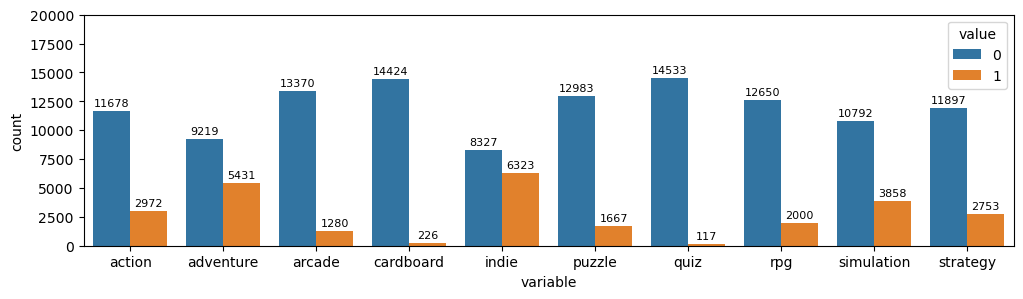

In [68]:
# displaying test set distribution as a proof of validation to our confusion matrices

display(y_test[genre_cols].apply(lambda x: x.value_counts(normalize=True)))

plt.figure(figsize=(12,3))
ax = sns.countplot(x="variable", hue="value", data=pd.melt(y_test[genre_cols]))
ax.set_ylim(0,20000)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=2, fontsize=8)

plt.show()

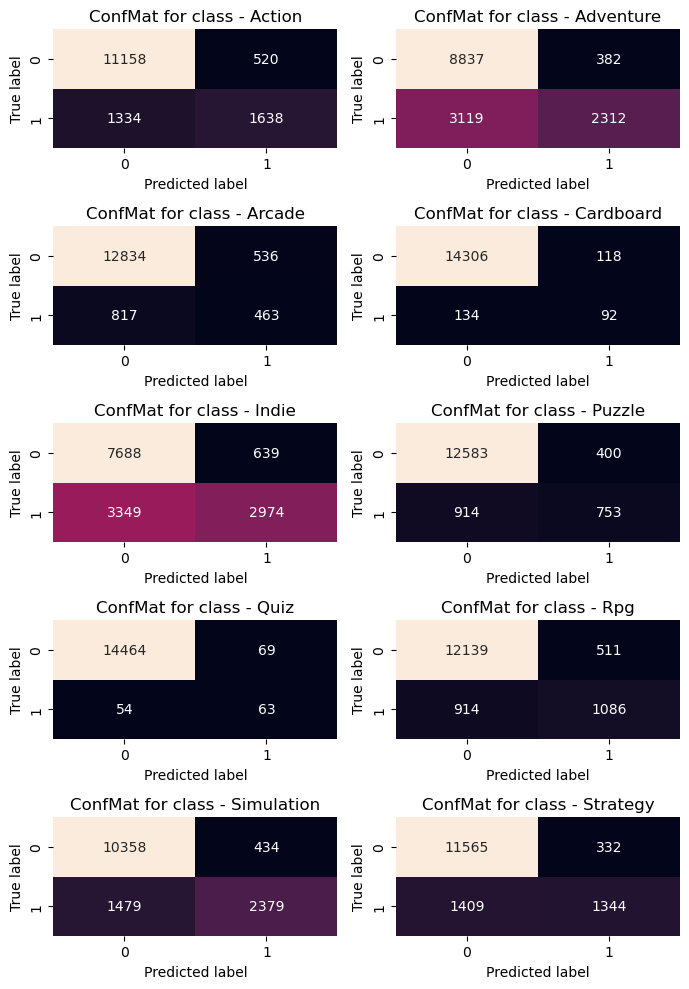

In [69]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
#     heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
#     heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right')
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("ConfMat for class - " + class_label.capitalize())
    
fig, ax = plt.subplots(5, 2, figsize=(7, 10))
    
for axes, cfs_matrix, label in zip(ax.flatten(), mlb_cm, genre_cols):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])

fig.tight_layout()
plt.show()

### 📝 Classification Report

In [70]:
print(metrics.classification_report(actual_df[genre_cols].values, thresholded_preds[genre_cols].values, target_names=genre_cols))

              precision    recall  f1-score   support

      action       0.76      0.55      0.64      2972
   adventure       0.86      0.43      0.57      5431
      arcade       0.46      0.36      0.41      1280
   cardboard       0.44      0.41      0.42       226
       indie       0.82      0.47      0.60      6323
      puzzle       0.65      0.45      0.53      1667
        quiz       0.48      0.54      0.51       117
         rpg       0.68      0.54      0.60      2000
  simulation       0.85      0.62      0.71      3858
    strategy       0.80      0.49      0.61      2753

   micro avg       0.77      0.49      0.60     26627
   macro avg       0.68      0.49      0.56     26627
weighted avg       0.78      0.49      0.60     26627
 samples avg       0.71      0.56      0.59     26627



### 📝 Getting F1 Score

In [71]:
for cat in genre_cols:
    
    print(f"Category: {cat}")
    print(f"Sklearn score: {metrics.f1_score(actual_df[cat], thresholded_preds[cat])}")
    print(f"torchmetrics score: {torchmetrics.functional.classification.binary_f1_score(torch.tensor(predictions_df[cat].values),torch.tensor(actual_df[cat].values))}")
#     print(f"torchmetrics score(orig): {torchmetrics.functional.classification.binary_f1_score(torch.tensor(thresholded_preds[cat].values),torch.tensor(actual_df[cat].values), threshold=0.5)}")
    print("#" * 30)
    print()

Category: action
Sklearn score: 0.6385964912280702
torchmetrics score: 0.6385964751243591
##############################

Category: adventure
Sklearn score: 0.5691076923076923
torchmetrics score: 0.569107711315155
##############################

Category: arcade
Sklearn score: 0.4063185607722685
torchmetrics score: 0.4063185751438141
##############################

Category: cardboard
Sklearn score: 0.42201834862385323
torchmetrics score: 0.4220183491706848
##############################

Category: indie
Sklearn score: 0.5986312399355878
torchmetrics score: 0.5986312627792358
##############################

Category: puzzle
Sklearn score: 0.5340425531914894
torchmetrics score: 0.5340425372123718
##############################

Category: quiz
Sklearn score: 0.5060240963855421
torchmetrics score: 0.5060241222381592
##############################

Category: rpg
Sklearn score: 0.603836530442035
torchmetrics score: 0.6038365364074707
##############################

Category: simulation
Skle

In [72]:
print(f"Sklearn score(micro): {metrics.f1_score(actual_df[genre_cols].values, thresholded_preds[genre_cols].values, average='micro')}")
print(f"torchmetrics score(micro): {torchmetrics.functional.classification.multilabel_f1_score(torch.tensor(thresholded_preds[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,average='macro')}")

print()
print(f"Sklearn score(macro): {metrics.f1_score(actual_df[genre_cols].values, thresholded_preds[genre_cols].values, average='macro')}")
print(f"torchmetrics score(macro): {torchmetrics.functional.classification.multilabel_f1_score(torch.tensor(thresholded_preds[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,average='macro')}")

print()
print(f"Sklearn score(weighted): {metrics.f1_score(actual_df[genre_cols].values, thresholded_preds[genre_cols].values, average='weighted')}")
print(f"torchmetrics score(weighted): {torchmetrics.functional.classification.multilabel_f1_score(torch.tensor(thresholded_preds[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,average='weighted')}")

Sklearn score(micro): 0.6001099102399707
torchmetrics score(micro): 0.5598720908164978

Sklearn score(macro): 0.5598720918034517
torchmetrics score(macro): 0.5598720908164978

Sklearn score(weighted): 0.5997279159576826
torchmetrics score(weighted): 0.599727988243103
